In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import tqdm
import math
from prettytable import PrettyTable
from torch.utils.data import DataLoader, Dataset
from argparse import Namespace
import pickle
import torch.optim as optim
import random
from collections import OrderedDict
import functools
import torcheval.metrics.functional as Feval
from torchvision.ops import sigmoid_focal_loss
from torcheval.metrics.functional import binary_f1_score
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall
from torch_receptive_field import receptive_field

from spconv.pytorch.utils import PointToVoxel
import spconv.pytorch as spconv
from spconv.pytorch.modules import SparseModule

from implicitmorph import utils, dataio, argument_parser

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from time import time
import wandb

seed = 1996
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

batch_size = 10

/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/functional.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  _TORCH_CUSTOM_FWD = amp.custom_fwd(cast_inputs=torch.float16)
/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/functional.py:97: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/functional.py:163: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/scratch-grete/usr/nimlucmo/mambaforge/envs/voxel_env/lib/python3.9/site-packages/spconv/pytorch/function

In [2]:
# import os

# # Directory where your .npy files are located
# npy_dir = '/scratch-emmy/usr/nimpede1/pcs_v7_volume_rotation/splits/'

# # List of .npy files you want to check
# npy_files = ['all.npy', 'labels.npy', 'test.npy', 'train.npy', 'val.npy']

# for npy_file in npy_files:
#     file_path = os.path.join(npy_dir, npy_file)
#     try:
#         # Load the .npy file
#         data = np.load(file_path, allow_pickle=True)
        
#         # Print the number of elements (neurons) in the file
#         print(f"Number of neurons in {npy_file}: {len(data)}")
#     except Exception as e:
#         print(f"Error loading {npy_file}: {e}")

In [3]:
# Training split
id_list_path = '/scratch-emmy/usr/nimpede1/pcs_v7_volume_rotation/splits/train.npy'
# id_list_path = '/scratch-emmy/usr/nimpede1/pcs_v7_volume_rotation/splits/train.npy'
experiment_folder = 'voxel_neuron_morph/logs/test'
id_list = np.load(id_list_path, allow_pickle=True)
opt = utils.load_config(experiment_folder)
opt.use_amp=argument_parser.t_or_f(opt.use_amp)
opt.normalization_per_shape = argument_parser.t_or_f(opt.normalization_per_shape)
opt.curriculum_learning = argument_parser.t_or_f(opt.curriculum_learning)
opt.should_early_stop = argument_parser.t_or_f(opt.should_early_stop)

opt.bce_loss = argument_parser.t_or_f(opt.bce_loss)
opt.occ_boundary_loss = argument_parser.t_or_f(opt.occ_boundary_loss)
opt.inter_loss = argument_parser.t_or_f(opt.inter_loss)
opt.normals_loss = argument_parser.t_or_f(opt.normals_loss)
opt.grad_loss = argument_parser.t_or_f(opt.grad_loss)
opt.l1_loss = argument_parser.t_or_f(opt.l1_loss)
opt.latent_kld_loss = argument_parser.t_or_f(opt.latent_kld_loss)
opt.latent_kld_prior_loss = argument_parser.t_or_f(opt.latent_kld_prior_loss)
opt.latent_norm_loss = argument_parser.t_or_f(opt.latent_norm_loss)

opt.n_shapes = int(opt.n_shapes)
opt.num_epochs = int(opt.num_epochs)
opt.lr = float(opt.lr)
opt.num_hidden_layers = int(opt.num_hidden_layers)
opt.hidden_features = int(opt.hidden_features)
opt.shape_dim = int(opt.shape_dim)
opt.on_surface_points = int(opt.on_surface_points)
opt.resolution = int(opt.resolution)

opt.batch_size = int(batch_size)

dataset_train = dataio.MicronsMinnie(pointcloud_path=opt.pointcloud_path,
                                      all_segment_splits=id_list,
                                      n_shapes=41476,
                                      on_surface_points=int(opt.on_surface_points),
                                      uniform_points=int(opt.uniform_points),
                                      bb_points=int(opt.bb_points),
                                      perturbed_points=int(opt.perturbed_points),
                                      normalization_per_shape=opt.normalization_per_shape,
                                      centering=opt.centering,
                                      rank=0)
# Validation split
id_list_path = '/scratch-emmy/usr/nimpede1/pcs_v7_volume_rotation/splits/val.npy'
experiment_folder = 'voxel_neuron_morph/logs/test'
id_list = np.load(id_list_path, allow_pickle=True)
opt = utils.load_config(experiment_folder)
opt.use_amp=argument_parser.t_or_f(opt.use_amp)
opt.normalization_per_shape = argument_parser.t_or_f(opt.normalization_per_shape)
opt.curriculum_learning = argument_parser.t_or_f(opt.curriculum_learning)
opt.should_early_stop = argument_parser.t_or_f(opt.should_early_stop)

opt.bce_loss = argument_parser.t_or_f(opt.bce_loss)
opt.occ_boundary_loss = argument_parser.t_or_f(opt.occ_boundary_loss)
opt.inter_loss = argument_parser.t_or_f(opt.inter_loss)
opt.normals_loss = argument_parser.t_or_f(opt.normals_loss)
opt.grad_loss = argument_parser.t_or_f(opt.grad_loss)
opt.l1_loss = argument_parser.t_or_f(opt.l1_loss)
opt.latent_kld_loss = argument_parser.t_or_f(opt.latent_kld_loss)
opt.latent_kld_prior_loss = argument_parser.t_or_f(opt.latent_kld_prior_loss)
opt.latent_norm_loss = argument_parser.t_or_f(opt.latent_norm_loss)

opt.n_shapes = int(opt.n_shapes)
opt.num_epochs = int(opt.num_epochs)
opt.lr = float(opt.lr)
opt.num_hidden_layers = int(opt.num_hidden_layers)
opt.hidden_features = int(opt.hidden_features)
opt.shape_dim = int(opt.shape_dim)
opt.on_surface_points = int(opt.on_surface_points)
opt.resolution = int(opt.resolution)

opt.batch_size = int(batch_size)

dataset_validation = dataio.MicronsMinnie(pointcloud_path=opt.pointcloud_path,
                                      all_segment_splits=id_list,
                                      n_shapes=4598,
                                      on_surface_points=int(opt.on_surface_points),
                                      uniform_points=int(opt.uniform_points),
                                      bb_points=int(opt.bb_points),
                                      perturbed_points=int(opt.perturbed_points),
                                      normalization_per_shape=opt.normalization_per_shape,
                                      centering=opt.centering,
                                      rank=0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

DLtrain = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                     worker_init_fn=seed_worker, generator=g)
DLval = DataLoader(dataset_validation, batch_size=batch_size, shuffle=True,
                   worker_init_fn=seed_worker, generator=g)
print(len(DLtrain))
print(len(DLval))


def to_dense(voxel_coords):
    voxel_coords = voxel_coords.long()
    dense_shape = torch.max(voxel_coords, dim=0).values + 1
    dense_tensor = torch.zeros(dense_shape.tolist(), dtype=torch.float32, device=DEVICE)
    dense_tensor[voxel_coords[:, 0], voxel_coords[:, 1], voxel_coords[:, 2]] = 1.0
    return dense_tensor


def voxelize_in_model(feats, batch_ids, batch_size, voxel_size, use_coords=True, use_feats=False, max_num_points_per_voxel=3, epsilon=1):
    voxel_coords, voxel_feats, v2p_maps = [], [], []
    total_len_voxels = 0

    for i in range(batch_size):
        feats_one_element = feats[batch_ids == i]

        min_range = torch.min(feats_one_element[:, :3], dim=0).values
        max_range = torch.max(feats_one_element[:, :3], dim=0).values + epsilon

        voxelizer = PointToVoxel(
            vsize_xyz=[voxel_size, voxel_size, voxel_size],
            coors_range_xyz= min_range.tolist() + max_range.tolist(),
            num_point_features=feats.shape[1],
            max_num_voxels=len(feats),
            max_num_points_per_voxel=max_num_points_per_voxel,
            device=DEVICE)
        voxel_feat, voxel_coord, _, v2p_map = voxelizer.generate_voxel_with_id(feats_one_element)
        assert torch.sum(v2p_map == -1) == 0
        voxel_coord[:, [0, 2]] = voxel_coord[:, [2, 0]]
        # voxel_coord = torch.cat((torch.ones((len(voxel_coord), 1), device=DEVICE)*i, voxel_coord), dim=1)

        # get mean feature of voxel
        zero_rows = torch.sum(voxel_feat == 0, dim=2) == voxel_feat.shape[2]
        voxel_feat[zero_rows] = float("nan")
        voxel_feat = torch.nanmean(voxel_feat, dim=1)
        if not use_coords:
            voxel_feat[:, :3] = torch.ones_like(voxel_feat[:, :3])
        if not use_feats:
            voxel_feat[:, 3:] = torch.ones_like(voxel_feat[:, 3:])
        voxel_feat = torch.hstack([voxel_feat[:, 3:], voxel_feat[:, :3]])
        
        voxel_coords.append(voxel_coord)
        voxel_feats.append(voxel_feat)
        v2p_maps.append(v2p_map + total_len_voxels)
        total_len_voxels += len(voxel_coord)

    voxel_feats = torch.cat(voxel_feats, dim=0)
    v2p_maps = torch.cat(v2p_maps, dim=0)
    spatial_shape = torch.cat(voxel_coords, dim=0).max(dim=0).values + 1
    # voxel_coords was originally a tensor of all neurons in a batch, now a list of that length

    return voxel_feats, voxel_coords, v2p_maps, spatial_shape[1:]


def transform_input(pointclouds):
    bs, N, _ = pointclouds.shape
    coords = pointclouds.reshape(-1,3).to(DEVICE)
    feats = torch.randn(N*bs,3, device=DEVICE)
    batch_ids = torch.arange(bs).repeat_interleave(int(N)).to(DEVICE)
    return coords, feats, batch_ids, bs

# Data: batch x 100 000 x 3
def voxelize(data, voxel_size):
    coords, feats, batch_ids, batch_size = transform_input(data)
    voxel_feats, voxel_coords, v2p_maps , spatial_shape = voxelize_in_model(torch.hstack([coords, feats]), batch_ids, batch_size, voxel_size)
    return voxel_feats, voxel_coords, v2p_maps , spatial_shape


def set_padding(data, grid_size):
    # Dimensions are Depth x Height x Width

    pad_left = math.floor((grid_size - data.shape[2]) / 2)
    pad_right = math.ceil((grid_size - data.shape[2]) / 2)
    pad_top = math.floor((grid_size - data.shape[1]) / 2)
    pad_bot = math.ceil((grid_size - data.shape[1]) / 2)
    pad_front = math.floor((grid_size - data.shape[0]) / 2)
    pad_back = math.ceil((grid_size - data.shape[0]) / 2)

    return F.pad(data, (pad_left, pad_right, pad_top, pad_bot, pad_front, pad_back))



# Plot ----------------------------------------------------------------------------------------------------
# def plot(data):
#     fig = plt.figure(figsize=(10,10))
#     ax = plt.axes(projection ='3d')
#     ax.voxels(data, facecolors='blue', edgecolor='k')


def plot(batch, grid_size, crop_percentage=0.1, neuron_idx=0):
    """
    Plot the ground truth of a single neuron from the dataloader.
    
    Args:
        batch (dictionary): Batch from the DataLoader.
        grid_size (int): The size of the grid for voxelizing the pointcloud.
        crop_percentage (float): Percentage of volume to crop from each side.
        index (int): Index of the element in the dataloader to visualize. Default is 0 (first element).
    """
    pointcloud = batch["pointcloud"]

    # Prepare voxel data
    voxel_feats, voxels_list, v2p_maps , spatial_shape = voxelize(pointcloud, voxel_size=2/grid_size)
    padded_list = []
    for idx, voxel_coords in enumerate(voxels_list):
        # Get the specified element from the dataloader
        if idx == neuron_idx:
            dense_tensor = to_dense(voxel_coords)
            padded_tensor = set_padding(dense_tensor, grid_size)
            padded_list.append(padded_tensor.unsqueeze(0).unsqueeze(0))  # 2x unsqueeze(0) to add dims for batch_size & channels

    # Concatenate all together & cast to float (required for model)
    voxels = torch.cat(padded_list, dim=0).float()

    # Calculate crop boundaries
    lower_bound = int(grid_size * crop_percentage)
    upper_bound = grid_size - lower_bound

    # Crop the ground truth volume
    cropped_voxels = voxels.squeeze(0).squeeze(0)[lower_bound:upper_bound, lower_bound:upper_bound, lower_bound:upper_bound]

    # Plot the cropped ground truth volume
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(cropped_voxels.cpu(), facecolors='blue', edgecolor='k')
    plt.title('3D Plot of Ground Truth Neuron')
    plt.show()


def plot_preds(model, dataloader, device, grid_size, best_threshold, bins=50, alpha=0.75, color="blue", edgecolor="black", crop_thresh=0.4):
    """
    Plot the histogram of prediction values, filtering out values below crop_thresh.
    
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (DataLoader): Dataloader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).
        grid_size (int): The size of the grid for voxelizing the pointcloud.
        best_threshold (float): The best threshold value to plot.
        bins (int): Number of bins for the histogram.
        alpha (float): Transparency level of the histogram.
        color (str): Color of the histogram.
        edgecolor (str): Edge color of the bins.
        crop_thresh (float): Threshold below which prediction values are not included in the histogram.
    """
    model.eval()
    all_preds = []

    with torch.no_grad():
        for iterations, data in enumerate(dataloader):
            pointcloud = data["pointcloud"].to(device)

            voxel_feats, voxels_list, v2p_maps , spatial_shape = voxelize(pointcloud, voxel_size=2/grid_size)
            padded_list = []
            # To Dense Step - Goal: Tensor of [batch_size, channel_size=1, depth, height, width]
            for voxel_coords in voxels_list:
                dense_tensor = to_dense(voxel_coords)
                padded_tensor = set_padding(dense_tensor, grid_size)
                padded_list.append(padded_tensor.unsqueeze(0).unsqueeze(0)) # 2x unsqueeze(0) to add dims for batch_size & channels
            
            # concat all together & cast to float (required for model)
            voxels = torch.cat(padded_list, dim=0).float()

            pred = model(voxels)
            preds = F.sigmoid(pred)
            all_preds.append(preds.cpu().numpy())

    # Flatten all predictions
    all_preds = np.concatenate(all_preds).flatten()

    # Filter prediction values based on the crop threshold
    filtered_preds = all_preds[all_preds >= crop_thresh]

    # Plot the histogram
    plt.hist(filtered_preds, bins=bins, alpha=alpha, color=color, edgecolor=edgecolor)
    plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {round(best_threshold, 5)}")
    plt.xlabel('Prediction Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Values')
    plt.legend()
    plt.show()


def plot_scores(train_scores, val_scores, best_threshold):
    """
    Plot the average scores for different thresholds and mark the best threshold.

    Args:
        avg_scores (dict): Dictionary with thresholds as keys and average scores as values.
        best_threshold (float): The threshold value that gives the best score.
    """
    thresholds = list(val_scores.keys())
    train_values = list(train_scores.values())
    val_values = list(val_scores.values())

    best_score_train = train_scores[best_threshold]
    best_score_val = val_scores[best_threshold]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, train_values, marker='o', linestyle='-', color='blue', label=f'Training F1 Scores')
    plt.plot(thresholds, val_values, marker='o', linestyle='-', color='darkgrey', label=f'Validation F1 Scores')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {round(best_threshold, 5)}')
    plt.xlabel('Threshold Values')
    plt.ylabel('Average F1 Score')
    # plt.title('Average F1 Scores between Prediction & GT for Different Thresholds')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


def plot_prediction(model, batch, device, grid_size, threshold=0.5, crop_percentage=0.1, alpha=0.75, neuron_idx=0, font_size=12):
    """
    Plot the prediction of a single neuron from the dataloader.

    Args:
        model (torch.nn.Module): The trained model.
        batch (dictionary): Batch from the DataLoader.
        device (torch.device): Device to run the model on (CPU or GPU).
        grid_size (int): The size of the grid for voxelizing the pointcloud.
        threshold (float): Threshold for converting probabilities to binary values.
        crop_percentage (float): Percentage of volume to crop from each side.
        neuron_idx (int): Index of the element in the dataloader to visualize. Default is 0 (first element).
        font_size (int): The font size for titles and legend.
    """
    model.eval()

    pointcloud = batch["pointcloud"].to(device)

    # Prepare voxel data
    voxel_feats, voxels_list, v2p_maps, spatial_shape = voxelize(pointcloud, voxel_size=2 / grid_size)
    padded_list = []
    for idx, voxel_coords in enumerate(voxels_list):
        # Get the specified element from the dataloader
        if idx == neuron_idx:
            dense_tensor = to_dense(voxel_coords)
            padded_tensor = set_padding(dense_tensor, grid_size)
            padded_list.append(padded_tensor.unsqueeze(0).unsqueeze(0))  # 2x unsqueeze(0) to add dims for batch_size & channels

    # Concatenate all together & cast to float (required for model)
    voxels = torch.cat(padded_list, dim=0).float()

    with torch.no_grad():
        pred = model(voxels)
        # Calculate IoU and F1 score
        iou_score = calculate_iou(pred, voxels, threshold)
        f1_score = calculate_f1(pred, voxels, threshold)

        pred = torch.sigmoid(pred)
        pred = pred.squeeze(0).squeeze(0)

    # Apply threshold
    pred = (pred > threshold).float()

    # Calculate crop boundaries
    lower_bound = int(grid_size * crop_percentage)
    upper_bound = grid_size - lower_bound

    # Crop the ground truth and prediction volumes
    voxels_cropped = voxels.squeeze(0).squeeze(0)[lower_bound:upper_bound, lower_bound:upper_bound, lower_bound:upper_bound]
    pred_cropped = pred[lower_bound:upper_bound, lower_bound:upper_bound, lower_bound:upper_bound]

    voxels_rotated = torch.rot90(voxels_cropped, k=1, dims=(1, 2))
    voxels_correct = torch.flip(voxels_rotated, dims=[2])

    pred_rotated = torch.rot90(pred_cropped, k=1, dims=(1, 2))
    pred_correct = torch.flip(pred_rotated, dims=[2])
    
    # Plot the cropped prediction and ground truth volumes
    fig = plt.figure(figsize=(20, 10))

    # Plot ground truth
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.voxels(voxels_correct.cpu(), facecolors='blue', edgecolor='none', alpha=alpha)
    ax1.set_title('Ground Truth Neuron', fontsize=font_size)

    # Plot prediction
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.voxels(pred_correct.cpu(), facecolors='blue', edgecolor='none', alpha=alpha)
    ax2.set_title('Predicted Neuron', fontsize=font_size)

    # Add legend with IoU and F1 score
    fig.legend(handles=[
        Patch(facecolor='blue', edgecolor='none', label=f'IoU: {iou_score:.4f}'),
        Patch(facecolor='blue', edgecolor='none', label=f'F1 Score: {f1_score:.4f}')
    ], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.85), fontsize=font_size)  # Adjusted fontsize to match title

    plt.show()


# Define the save function to create a checkpoint
def save_checkpoint(state, optimizer, num_iterations, name="model"):
    path = f"/home/nimlucmo/voxel_neuron_morph/model_final/models/{name}.pth"
    torch.save({
        'num_iterations': num_iterations,
        'model_state_dict': state.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

# Define the load function with default path
def load_model(state, optimizer, name):
    path = f"/home/nimlucmo/voxel_neuron_morph/{name}.pth"
    checkpoint = torch.load(path)
    state.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['num_iterations']
    state.eval()  # Set the model state to evaluation mode
    return state, optimizer, epoch


class NotGeneralizingException(Exception):
    pass


class FocalLoss(nn.Module):
    """
    Args:
        alpha: Weighting parameter to balance loss for positive and negative examples.
        gamma: Weighting parameter to balance loss for hard and easy examples.
    """
    def __init__(self, alpha=0.25, gamma=2):
        # Einer Class imbalance den sonst hoch
        # ...
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)

        BCE_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')

        # converts the logits to probabilities
        probs = torch.sigmoid(preds)
        # This effectively selects the predicted probability p if the target is 1 and 1 - p if the target is 0.
        pt = probs * targets + (1 - probs) * (1 - targets)

        F_loss = (self.alpha * (1 - pt) ** self.gamma) * BCE_loss
        return F_loss.mean()


class FocalLossWrapper(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLossWrapper, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        return sigmoid_focal_loss(preds, targets, alpha=self.alpha, gamma=self.gamma, reduction='mean')


def calculate_iou(pred, targets, threshold=0.5):
    """
    Calculate the IoU (Jaccard Index) for a given threshold using torchmetrics' BinaryJaccardIndex.
    
    Args:
        pred (torch.Tensor): Raw predictions (logits) from the model.
        targets (torch.Tensor): Ground truth values.
        threshold (float): Threshold for converting logits to binary predictions.
    
    Returns:
        float: IoU score.
    """
    # Apply sigmoid to the raw predictions (logits) to get probabilities
    probs = torch.sigmoid(pred)
    
    # Apply the threshold to obtain binary predictions
    preds = (probs > threshold).float()
    
    # Flatten the predictions and targets
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Instantiate the BinaryJaccardIndex metric
    binary_jaccard = BinaryJaccardIndex().to(preds.device)
    
    # Calculate the IoU
    iou = binary_jaccard(preds, targets.int())
    
    return iou.item()


def calculate_f1(pred, targets, threshold=0.5):
    """
    Calculate the F1 score for a given threshold using torcheval's binary_f1_score.
    
    Args:
        pred (torch.Tensor): Raw predictions (logits) from the model (batch_size, channels=1, depth, height, width).
        targets (torch.Tensor): Ground truth values (batch_size, channels=1, depth, height, width).
        threshold (float): Threshold for converting logits to binary predictions.
    
    Returns:
        float: F1 score.
    """
    # Apply sigmoid to the raw predictions (logits) to get probabilities
    probs = torch.sigmoid(pred)
    
    # Apply the threshold to obtain binary predictions
    preds = (probs > threshold).float()
    
    # Ensure targets are binary (0 or 1)
    targets = targets.float()
    
    # Flatten the predictions and targets for metric calculation
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Calculate the F1 score using torcheval's binary_f1_score
    f1 = binary_f1_score(preds, targets)
    return f1.item()

def find_best_threshold(model, dataloader, device, grid_size, metric_fn=calculate_iou, thresholds=None):
    """
    Find the best threshold that maximizes the specified metric over Neurons of a dataloader.
    
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (DataLoader): Dataloader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).
        grid_size (int): The size of the grid for voxelizing the pointcloud.
        metric_fn (function): The function to use for evaluating thresholds (e.g., calculate_iou, calculate_f1).
        thresholds (numpy array): Array of thresholds to evaluate.
    
    Returns:
        float: Best threshold and its average score for the specified metric.
    """
    if thresholds is None:
        thresholds = np.arange(0.1, 1.0, 0.05)

    model.eval()
    scores = {threshold: [] for threshold in thresholds}

    with torch.no_grad():
        for iterations, data in enumerate(dataloader):
            pointcloud = data["pointcloud"].to(device)

            voxel_feats, voxels_list, v2p_maps , spatial_shape = voxelize(pointcloud, voxel_size=2/grid_size)
            padded_list = []
            # To Dense Step - Goal: Tensor of [batch_size, channel_size=1, depth, height, width]
            for voxel_coords in voxels_list:
                dense_tensor = to_dense(voxel_coords)
                padded_tensor = set_padding(dense_tensor, grid_size)
                padded_list.append(padded_tensor.unsqueeze(0).unsqueeze(0)) # 2x unsqueeze(0) to add dims for batch_size & channels
            
            # concat all together & cast to float (required for model)
            voxels = torch.cat(padded_list, dim=0).float()

            pred = model(voxels)

            for threshold in thresholds:
                score = metric_fn(pred, voxels, threshold)
                scores[threshold].append(score)

    avg_scores = {threshold: np.mean(scores) for threshold, scores in scores.items()}
    best_threshold = max(avg_scores, key=avg_scores.get)

    # Round this value to the first 5 decimals

    return best_threshold, avg_scores


class ResidualBlock(nn.Module):
    """(Conv3d => BatchNorm => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        
        if in_channels == out_channels:
            self.i_branch = nn.Identity()
        else:
            self.i_branch = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)

        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size,
                      padding=kernel_size // 2, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size,
                      padding=kernel_size // 2, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        identity = self.i_branch(x)
        x = self.double_conv(x)
        x2 = x + identity
        return x2


class DoubleConv(nn.Module):
    """(Conv3d => BatchNorm => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, kernel_size=3, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        if residual:
            self.block = ResidualBlock(in_channels, out_channels, kernel_size)
        else:
            self.block = nn.Sequential(
                nn.Conv3d(in_channels, mid_channels, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm3d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(mid_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.block(x)


class Encoder(nn.Module):
    """Downscaling with MaxPool3d then ResidualBlock"""

    def __init__(self, in_channels, out_channels, residual=False):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels, residual=residual)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Decoder(nn.Module):
    """Upscaling with Upsample then ResidualBlock"""

    def __init__(self, in_channels, out_channels, transpose=True, residual=False):
        super().__init__()

        if transpose:
            self.up = self.up = nn.ConvTranspose3d(in_channels, in_channels, kernel_size=2, stride=2)
        else:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            # Instead of nn.ConvTranspose3d: Better performance Upsample quicker, still weights through Conv3d, BUT only latent decoder does not work
                
        self.conv = DoubleConv(in_channels, out_channels, kernel_size=1, residual=residual)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x
        

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class AE(nn.Module):
    """AE model which takes a 5D tensor as input"""

    def __init__(self, n_channels, n_classes, base_channels=32, num_blocks=4, transpose=True, residual=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        # n_channels = n_classes -> input & ouput should have 1 channel dimension
        self.num_blocks = num_blocks
        self.residual = residual

        self.block_channels = [base_channels * (2 ** i) for i in range(num_blocks + 1)]
        # The + 1 at the end is need, because the incoming and outconv layer have to be accounter for as well

        self.incoming = DoubleConv(n_channels, self.block_channels[0], residual=residual)
        
        self.encoders = nn.ModuleList()
        for i in range(num_blocks):
            self.encoders.append(Encoder(self.block_channels[i], self.block_channels[i + 1], residual=residual))

        # Decoder
        self.decoders = nn.ModuleList()
        for i in range(num_blocks, 0, -1):
            self.decoders.append(Decoder(self.block_channels[i], self.block_channels[i - 1], transpose=transpose, residual=residual))
        
        # 1 because occupied or not
        self.outconv = OutConv(self.block_channels[0], n_classes)

        self.maxpool = nn.MaxPool3d(2)

    def forward(self, x, part_idxs=None):
        x = self.incoming(x)
        feats = [x]
        
        # Encoder
        for encoder in self.encoders:
            x = encoder(x)
            feats.append(x)

        latent_space = x

        if part_idxs is not None:
            latent_parts = [latent_space[:,
                                         :,
                                         part_idx[0]:part_idx[0]+1,
                                         part_idx[1]:part_idx[1]+1,
                                         part_idx[2]:part_idx[2]+1] for part_idx in part_idxs]
            latent_space = torch.cat(latent_parts, dim=0)

        x = latent_space

        # Decoder path
        for decoder in self.decoders:
            x = decoder(x)

        # Last/Output layer
        x = self.outconv(x)

        return x
    
    def get_occupied_indices(self, x):
        # Get the indices of occupied latent cubes
        for _ in range(self.num_blocks):
            x = self.maxpool(x)
        occupied = (x > 0).nonzero(as_tuple=False)[:, 2:]  
        return occupied


def get_random_part_idx(indices):
    # Random neuron ID
    idx = random.randint(0, len(indices) - 1)
    return idx, indices[idx]


def get_unique_part_indices(occupied_indices, latent_dim, num_latent_cubes):
    occupied_indices = occupied_indices.tolist()  # Convert tensor to list for easier manipulation
    if len(occupied_indices) <= 0:
        prob = 0
    else:
        prob = 0.5
    occupied_part_idxs = []
    random_part_idxs = []
    
    if num_latent_cubes == 1:
        if random.random() < prob:
            _, occupied_idx = get_random_part_idx(occupied_indices)
            occupied_part_idxs.append(occupied_idx)
        else:
            random_idx = torch.randint(0, latent_dim, (3,)).tolist()
            random_part_idxs.append(random_idx)
    else:
        num_occupied = min(num_latent_cubes // 2, len(occupied_indices))
        num_random = min(num_latent_cubes - num_occupied, (latent_dim ** 3) - num_occupied)
        # to limit the number of cubes to the maximum langth of the latent cube (in 8x8x8 cube=512)
        
        while len(occupied_part_idxs) < num_occupied:
            idx, individual_occupied_idx = get_random_part_idx(occupied_indices)
            occupied_part_idxs.append(individual_occupied_idx)
            occupied_indices.remove(individual_occupied_idx)
        
        while len(random_part_idxs) < num_random:
            random_idx = torch.randint(0, latent_dim, (3,)).tolist()
            if random_idx not in occupied_part_idxs and random_idx not in random_part_idxs:
                random_part_idxs.append(random_idx)

    combined_list = occupied_part_idxs + random_part_idxs
    return combined_list


def validate(model, loader, loss_fn, device, grid_size, num_latent_cubes):
    model.eval()
    total_loss = 0
    total_f1 = 0
    total_iou = 0

    with torch.no_grad():
        for iterations, data in enumerate(loader):
            pointcloud = data["pointcloud"].to(device)

            voxel_feats, voxels_list, v2p_maps , spatial_shape = voxelize(pointcloud, voxel_size=2/grid_size)
            padded_list = []
            # To Dense Step - Goal: Tensor of [batch_size, channel_size=1, depth, height, width]
            for voxel_coords in voxels_list:
                dense_tensor = to_dense(voxel_coords)
                padded_tensor = set_padding(dense_tensor, grid_size)
                padded_list.append(padded_tensor.unsqueeze(0).unsqueeze(0)) # 2x unsqueeze(0) to add dims for batch_size & channels
        
            # concat all together & cast to float (required for model)
            voxels = torch.cat(padded_list, dim=0).float()

            # To get the depth of the model
            n_blocks = len(model.block_channels) - 1
            reduction = 2**n_blocks
            latent_dim = int(grid_size / reduction)
            
            if num_latent_cubes == 0:
                part_idx = None
                pred = model(voxels, part_idx)

                loss = loss_fn(pred, voxels)
            else:
                with torch.no_grad():
                    occupied_indices = model.get_occupied_indices(voxels)
                unique_idxs = get_unique_part_indices(occupied_indices, latent_dim, num_latent_cubes)

                pred_partial = model(voxels, unique_idxs)
                # additionally calculate a model for metric calculation
                pred = model(voxels, None)

                gt_parts = []
                for part_idx in unique_idxs:
                    gt_part = voxels[:,
                                    :,
                                    part_idx[0]*reduction:(part_idx[0]+1)*reduction,
                                    part_idx[1]*reduction:(part_idx[1]+1)*reduction,
                                    part_idx[2]*reduction:(part_idx[2]+1)*reduction]
                    gt_parts.append(gt_part)
                gt = torch.cat(gt_parts, dim=0)

                loss = loss_fn(pred_partial, gt)

            # Calculate the Metrics over prediction and whole ground truth
            f1 = calculate_f1(pred, voxels)
            iou = calculate_iou(pred, voxels)

            total_loss += loss.item()
            total_f1 += f1
            total_iou += iou
    
        avg_loss = total_loss / len(loader)
        avg_f1 = total_f1 / len(loader)
        avg_iou = total_iou / len(loader)

    print(f"Validation Loss: {avg_loss}, F1 Metric: {avg_f1}, IoU Metric: {avg_iou}")
    return avg_loss, avg_f1, avg_iou


def run(model, train_loader, val_loader, loss_fn, optimizer, scheduler, n_iter, n_epochs,
                 device, grid_size, patience, num_latent_cubes=0, save_check=False):
    prev_f1 = float(0)
    prev_iou = float(0)
    p_counter = 0
    # Iterations per epoch
    iterations_epoch = len(train_loader)

    current_iter = 0
    validation_iters = [0, iterations_epoch // 3, 2 * (iterations_epoch // 3)]

    for epoch in range(n_epochs):
        model.train()

        for iterations, data in enumerate(train_loader):
            current_iter += 1
            current_lr = scheduler.optimizer.param_groups[0]['lr']

            pointcloud = data["pointcloud"].to(device)
            
            optimizer.zero_grad()

            voxel_feats, voxels_list, v2p_maps , spatial_shape = voxelize(pointcloud, voxel_size=2/grid_size)
            
            padded_list = []
            # To Dense Step - Goal: Tensor of [batch_size, channel_size=1, depth, height, width]
            for voxel_coords in voxels_list:
                dense_tensor = to_dense(voxel_coords)
                padded_tensor = set_padding(dense_tensor, grid_size)
                padded_list.append(padded_tensor.unsqueeze(0).unsqueeze(0)) # 2x unsqueeze(0) to add dims for batch_size & channels
        
            # concat all together & cast to float (required for model)
            voxels = torch.cat(padded_list, dim=0).float()

            # To get the depth of the model
            n_blocks = len(model.block_channels) - 1
            reduction = 2**n_blocks
            latent_dim = int(grid_size / reduction)

            if num_latent_cubes == 0:
                part_idx = None
                pred = model(voxels, part_idx)

                loss = loss_fn(pred, voxels)
            else:
                with torch.no_grad():
                    occupied_indices = model.get_occupied_indices(voxels)
                unique_idxs = get_unique_part_indices(occupied_indices, latent_dim, num_latent_cubes)
                
                pred_partial = model(voxels, unique_idxs)
                with torch.no_grad():
                    # additionally calculate a model for metric calculation
                    pred = model(voxels, None)

                gt_parts = []
                for part_idx in unique_idxs:
                    gt_part = voxels[:,
                                    :,
                                    part_idx[0]*reduction:(part_idx[0]+1)*reduction,
                                    part_idx[1]*reduction:(part_idx[1]+1)*reduction,
                                    part_idx[2]*reduction:(part_idx[2]+1)*reduction]
                    gt_parts.append(gt_part)
                gt = torch.cat(gt_parts, dim=0)

                loss = loss_fn(pred_partial, gt)
            
            # Calculate the Metrics over prediction and whole ground truth
            f1 = calculate_f1(pred, voxels)
            iou = calculate_iou(pred, voxels)
            
            # Backwards
            loss.backward()
            optimizer.step()
            
            print(f"Iteration {current_iter}/{n_iter}")
            print(f"Training Loss: {loss.item()}, F1 Metric: {f1}, IoU Metric: {iou}")
            wandb.log({"train_loss": loss.item(),
                "train_metric_f1": f1,
                "train_metric_iou": iou,
                "learning_rate": current_lr,
                "iteration": current_iter})

            if iterations in validation_iters or current_iter >= n_iter:
                if current_iter >= n_iter:
                    print(f"Final validation check before ending")
                
                avg_val_loss, avg_val_metric_f1, avg_val_metric_iou = validate(model=model, loader=val_loader, loss_fn=loss_fn,
                                                                            device=device, grid_size=grid_size,num_latent_cubes=num_latent_cubes)

                wandb.log({"val_loss": avg_val_loss,
                        "val_metric_f1": avg_val_metric_f1,
                        "val_metric_iou": avg_val_metric_iou,
                        "learning_rate": current_lr,
                        "iteration": current_iter})
                
                if avg_val_metric_f1 > prev_f1:
                    prev_f1 = avg_val_metric_f1
                    p_counter = 0
                    best_iteration = current_iter
                    
                    if save_check==True and current_iter > (n_iter / 4):
                        print(f"Validation metric (F1 score) improved. Saving model checkpoint at iteration {current_iter}.")
                        save_checkpoint(model, optimizer, current_iter, f"{grid_size}_bs{batch_size}_nLat{num_latent_cubes}_a{alpha}g{gamma}-lr{lr}_F1")
                # else:
                    # p_counter += 1
                    # if p_counter >= patience:
                    #     print(f"Early stopping at epoch {epoch}. Best epoch was {best_epoch} with validation loss {prev_val_loss}.")
                    #     raise NotGeneralizingException

                if avg_val_metric_iou > prev_iou:
                    prev_iou = avg_val_metric_iou
                    if save_check==True and current_iter > (n_iter / 4):
                        print(f"Validation metric (IoU) improved. Saving model checkpoint at iteration {current_iter}.")
                        save_checkpoint(model, optimizer, current_iter, f"{grid_size}_bs{batch_size}_nLat{num_latent_cubes}_a{alpha}g{gamma}-lr{lr}_IoU")
                if current_iter >= n_iter:
                    print(f"Training completed. Best model state was at iteration {best_iteration} with validation metric of {prev_f1}.")
                    return
                model.train()
                
            scheduler.step()

    print(f"Training completed. Best model state was at iteration {best_iteration} with validation metric of {prev_f1}.")



grid_size = 128
voxel_size = 2/grid_size

target_latent_size = 8
num_blocks = int(math.log2(grid_size / target_latent_size))
base_channels = 32

num_latent_cubes = 10

n_iter = 60000
n_epochs = int((n_iter/len(DLtrain)) + 1)
patience = n_iter / 5
pct_percentage = 0.05
warmup_iter = int(n_iter * pct_percentage)

alpha = 0.75
gamma = 2.2
lr = 1e-3

model = AE(n_channels=1,n_classes=1, base_channels=base_channels, num_blocks=num_blocks, transpose=True, residual=True).to(DEVICE)
# grid_size / 2**(num_blocks) = number of dim length at lowest point

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# loss_fn = FocalLoss(alpha=alpha, gamma=gamma)
loss_fn = FocalLossWrapper(alpha=alpha, gamma=gamma)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=n_iter, 
                                          pct_start=pct_percentage, anneal_strategy='cos', cycle_momentum=False)

on surface: 5000 uniform: 2000 bb: 2000 perturbed: 1000 total: 10000 encoder: 100000
0 [    0     1     2 ... 41473 41474 41475]
on surface: 5000 uniform: 2000 bb: 2000 perturbed: 1000 total: 10000 encoder: 100000
0 [   0    1    2 ... 4595 4596 4597]
4148
460


In [4]:
# wandb.init(
#     project="HyperTest64",
#     name=f"{grid_size},bs{opt.batch_size},nLat{num_latent_cubes}_a{alpha}g{gamma}-lr{lr}"
# )
# run_training(model, DLtrain, DLval, loss_fn, optimizer, scheduler, n_epochs=n_epochs, device=DEVICE,
#              grid_size=grid_size, patience=int(patience), num_latent_cubes=num_latent_cubes,
#              save_check=True)

## Model Prediction Plots

In [5]:
# Test split
id_list_path = '/scratch-emmy/usr/nimpede1/pcs_v7_volume_rotation/splits/test.npy'
experiment_folder = 'voxel_neuron_morph/logs/test'
id_list = np.load(id_list_path, allow_pickle=True)
opt = utils.load_config(experiment_folder)
opt.use_amp=argument_parser.t_or_f(opt.use_amp)
opt.normalization_per_shape = argument_parser.t_or_f(opt.normalization_per_shape)
opt.curriculum_learning = argument_parser.t_or_f(opt.curriculum_learning)
opt.should_early_stop = argument_parser.t_or_f(opt.should_early_stop)

opt.bce_loss = argument_parser.t_or_f(opt.bce_loss)
opt.occ_boundary_loss = argument_parser.t_or_f(opt.occ_boundary_loss)
opt.inter_loss = argument_parser.t_or_f(opt.inter_loss)
opt.normals_loss = argument_parser.t_or_f(opt.normals_loss)
opt.grad_loss = argument_parser.t_or_f(opt.grad_loss)
opt.l1_loss = argument_parser.t_or_f(opt.l1_loss)
opt.latent_kld_loss = argument_parser.t_or_f(opt.latent_kld_loss)
opt.latent_kld_prior_loss = argument_parser.t_or_f(opt.latent_kld_prior_loss)
opt.latent_norm_loss = argument_parser.t_or_f(opt.latent_norm_loss)

opt.n_shapes = int(opt.n_shapes)
opt.num_epochs = int(opt.num_epochs)
opt.lr = float(opt.lr)
opt.num_hidden_layers = int(opt.num_hidden_layers)
opt.hidden_features = int(opt.hidden_features)
opt.shape_dim = int(opt.shape_dim)
opt.on_surface_points = int(opt.on_surface_points)
opt.resolution = int(opt.resolution)

opt.batch_size = int(batch_size)

dataset_test = dataio.MicronsMinnie(pointcloud_path=opt.pointcloud_path,
                                      all_segment_splits=id_list,
                                      n_shapes=10,
                                      on_surface_points=int(opt.on_surface_points),
                                      uniform_points=int(opt.uniform_points),
                                      bb_points=int(opt.bb_points),
                                      perturbed_points=int(opt.perturbed_points),
                                      normalization_per_shape=opt.normalization_per_shape,
                                      centering=opt.centering,
                                      rank=0)

DLtest = DataLoader(dataset_test, batch_size=batch_size, shuffle=True,
                    worker_init_fn=seed_worker, generator=g)

on surface: 5000 uniform: 2000 bb: 2000 perturbed: 1000 total: 10000 encoder: 100000
0 [0 1 2 3 4 5 6 7 8 9]


In [6]:
datat = next(iter(DLtrain))
datav = next(iter(DLval))
datatest = next(iter(DLtest))

In [7]:
datatest["pointcloud"].shape

torch.Size([10, 100000, 3])

In [8]:
def evaluate_precision_recall(model, dataloader, device, grid_size):
    """
    Evaluate the model's precision and recall at a default threshold of 0.5 over Neurons in a dataloader.
    
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (DataLoader): Dataloader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).
        grid_size (int): The size of the grid for voxelizing the pointcloud.
    
    Returns:
        tuple: A tuple containing the average precision and recall.
    """
    model.eval()
    precision_scores = []
    recall_scores = []

    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)

    with torch.no_grad():
        for iterations, data in enumerate(dataloader):
            pointcloud = data["pointcloud"].to(device)

            voxel_feats, voxels_list, v2p_maps, spatial_shape = voxelize(pointcloud, voxel_size=2/grid_size)
            padded_list = []
            # To Dense Step - Goal: Tensor of [batch_size, channel_size=1, depth, height, width]
            for voxel_coords in voxels_list:
                dense_tensor = to_dense(voxel_coords)
                padded_tensor = set_padding(dense_tensor, grid_size)
                padded_list.append(padded_tensor.unsqueeze(0).unsqueeze(0))  # 2x unsqueeze(0) to add dims for batch_size & channels
            
            # Concatenate all together & cast to float (required for model)
            voxels = torch.cat(padded_list, dim=0).float()

            # Get model predictions
            pred = model(voxels)
            pred_probs = torch.sigmoid(pred)  # Apply sigmoid to get probabilities

            # Binarize predictions at the threshold of 0.5
            preds = (pred_probs > 0.5).float()

            # Calculate precision and recall
            precision = precision_metric(preds, voxels.int())
            recall = recall_metric(preds, voxels.int())

            precision_scores.append(precision.item())
            recall_scores.append(recall.item())

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    return avg_precision, avg_recall

### Dense 128

In [9]:
num_latent_cubes = 0
grid_size = 128
voxel_size = 2 / grid_size

lmodel = AE(n_channels=1,n_classes=1, base_channels=32, num_blocks=4, transpose=True, residual=True).to(DEVICE)
loptimizer = torch.optim.AdamW(lmodel.parameters(), lr=1e-3)

model_dense128, optim_load128, n_iter_run128 = load_model(lmodel, loptimizer, name="model_final/models/50k/128_bs10_nLat0_a0.75g2.2-lr0.001_F1")

n_iter_run128

/scratch/tmp/nimlucmo/ipykernel_130880/1389452912.py:400: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


50000

In [9]:
summary(model_dense128, [batch_size, 1, grid_size, grid_size, grid_size])

Layer (type:depth-idx)                                  Output Shape              Param #
AE                                                      [10, 1, 128, 128, 128]    --
├─DoubleConv: 1-1                                       [10, 32, 128, 128, 128]   --
│    └─ResidualBlock: 2-1                               [10, 32, 128, 128, 128]   --
│    │    └─Conv3d: 3-1                                 [10, 32, 128, 128, 128]   32
│    │    └─Sequential: 3-2                             [10, 32, 128, 128, 128]   28,640
├─ModuleList: 1-2                                       --                        --
│    └─Encoder: 2-2                                     [10, 64, 64, 64, 64]      --
│    │    └─Sequential: 3-3                             [10, 64, 64, 64, 64]      168,192
│    └─Encoder: 2-3                                     [10, 128, 32, 32, 32]     --
│    │    └─Sequential: 3-4                             [10, 128, 32, 32, 32]     672,256
│    └─Encoder: 2-4                           

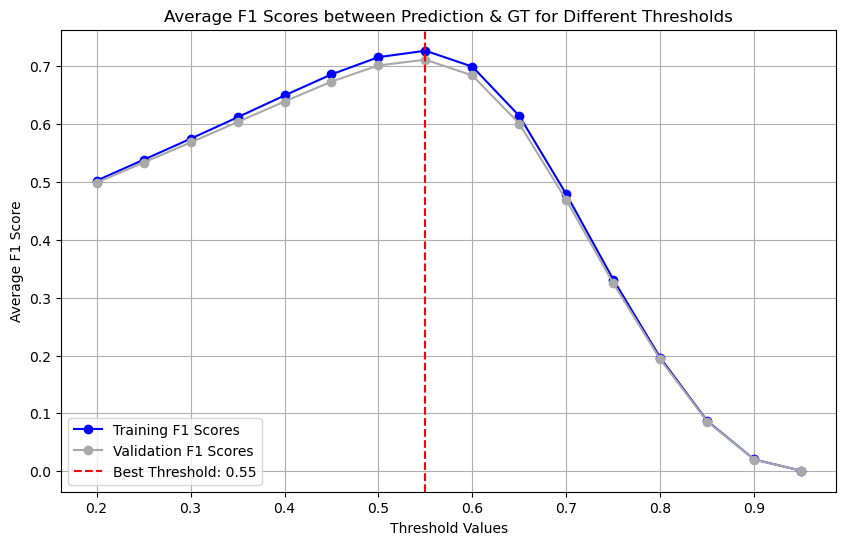

In [10]:
best_threshold_train_dense128, avg_scores_train_dense128 = find_best_threshold(model_dense128, DLtrain, DEVICE, grid_size=grid_size, metric_fn=calculate_f1, thresholds=np.arange(0.2, 1.0, 0.05))
best_threshold_val_dense128, avg_scores_val_dense128 = find_best_threshold(model_dense128, DLval, DEVICE, grid_size=grid_size, metric_fn=calculate_f1, thresholds=np.arange(0.2, 1.0, 0.05))

plot_scores(avg_scores_train_dense128, avg_scores_val_dense128, best_threshold_val_dense128)

# Best threshold at 0.55

In [11]:
print(avg_scores_train_dense128)
print(avg_scores_val_dense128)

{0.2: 0.5024232330122242, 0.25: 0.5385305333160504, 0.3: 0.5748542025613463, 0.35: 0.6119596061647915, 0.39999999999999997: 0.6496934037630445, 0.44999999999999996: 0.68618765438879, 0.49999999999999994: 0.7159778809420972, 0.5499999999999999: 0.7270786272237938, 0.5999999999999999: 0.699513354449171, 0.6499999999999999: 0.614196125256291, 0.7: 0.4788487052676073, 0.7499999999999998: 0.33133077585177, 0.7999999999999998: 0.19614356426071294, 0.8499999999999999: 0.08677216846291101, 0.8999999999999999: 0.020315817963662434, 0.9499999999999997: 0.0007976268599344596}
{0.2: 0.49897162849488463, 0.25: 0.533784427979718, 0.3: 0.5685086594975512, 0.35: 0.6036822389001432, 0.39999999999999997: 0.6392488329306892, 0.44999999999999996: 0.6736660133237424, 0.49999999999999994: 0.7016138830910559, 0.5499999999999999: 0.7115505844354629, 0.5999999999999999: 0.6843217743479687, 0.6499999999999999: 0.600807616179404, 0.7: 0.46877073159684307, 0.7499999999999998: 0.32482362049429314, 0.79999999999999

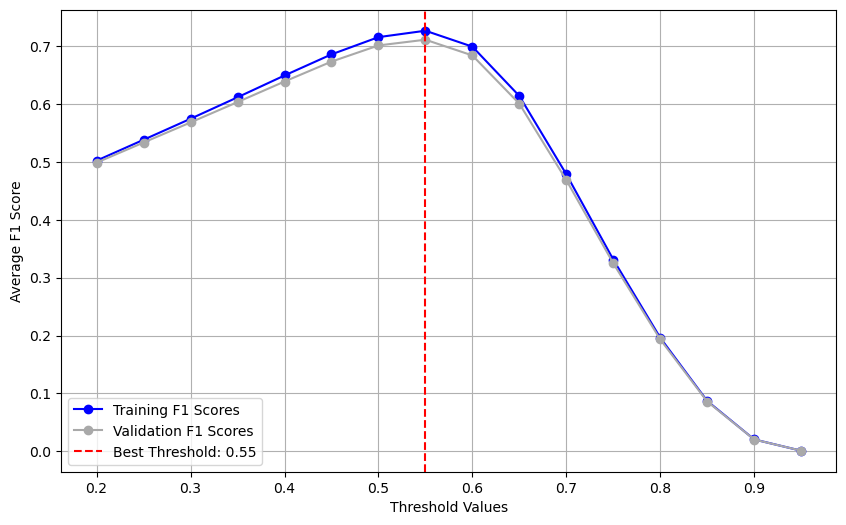

In [10]:
avg_scores_train_dense128_save = {0.2: 0.5024232330122242, 0.25: 0.5385305333160504, 0.3: 0.5748542025613463, 0.35: 0.6119596061647915, 0.4: 0.6496934037630445, 0.45: 0.68618765438879, 0.5: 0.7159778809420972, 0.55: 0.7270786272237938, 0.6: 0.699513354449171, 0.65: 0.614196125256291, 0.7: 0.4788487052676073, 0.75: 0.33133077585177, 0.8: 0.19614356426071294, 0.85: 0.08677216846291101, 0.9: 0.020315817963662434, 0.95: 0.0007976268599344596}
avg_scores_val_dense128_save = {0.2: 0.49897162849488463, 0.25: 0.533784427979718, 0.3: 0.5685086594975512, 0.35: 0.6036822389001432, 0.4: 0.6392488329306892, 0.45: 0.6736660133237424, 0.5: 0.7016138830910559, 0.55: 0.7115505844354629, 0.6: 0.6843217743479687, 0.65: 0.600807616179404, 0.7: 0.46877073159684307, 0.75: 0.32482362049429314, 0.8: 0.19328586987179258, 0.85: 0.08585154329952986, 0.9: 0.020197384869274887, 0.95: 0.000834544185889409}
plot_scores(avg_scores_train_dense128_save, avg_scores_val_dense128_save, best_threshold=0.55)

### nLat Model 128

In [11]:
num_latent_cubes = 10
grid_size = 128
voxel_size = 2 / grid_size

lmodel = AE(n_channels=1,n_classes=1, base_channels=32, num_blocks=4, transpose=True, residual=True).to(DEVICE)
loptimizer = torch.optim.AdamW(lmodel.parameters(), lr=1e-3)

model_nLat128, optim_load128, n_iter_run128 = load_model(lmodel, loptimizer, name="model_final/models/50k/128_bs10_nLat10_a0.75g2.2-lr0.001_F1")

n_iter_run128

/scratch/tmp/nimlucmo/ipykernel_130880/1389452912.py:400: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


50000

In [11]:
summary(model_nLat128, [batch_size, 1, grid_size, grid_size, grid_size])

# Same model in terms of parameter, but smaller tensor when predicting

Layer (type:depth-idx)                                  Output Shape              Param #
AE                                                      [10, 1, 128, 128, 128]    --
├─DoubleConv: 1-1                                       [10, 32, 128, 128, 128]   --
│    └─ResidualBlock: 2-1                               [10, 32, 128, 128, 128]   --
│    │    └─Conv3d: 3-1                                 [10, 32, 128, 128, 128]   32
│    │    └─Sequential: 3-2                             [10, 32, 128, 128, 128]   28,640
├─ModuleList: 1-2                                       --                        --
│    └─Encoder: 2-2                                     [10, 64, 64, 64, 64]      --
│    │    └─Sequential: 3-3                             [10, 64, 64, 64, 64]      168,192
│    └─Encoder: 2-3                                     [10, 128, 32, 32, 32]     --
│    │    └─Sequential: 3-4                             [10, 128, 32, 32, 32]     672,256
│    └─Encoder: 2-4                           

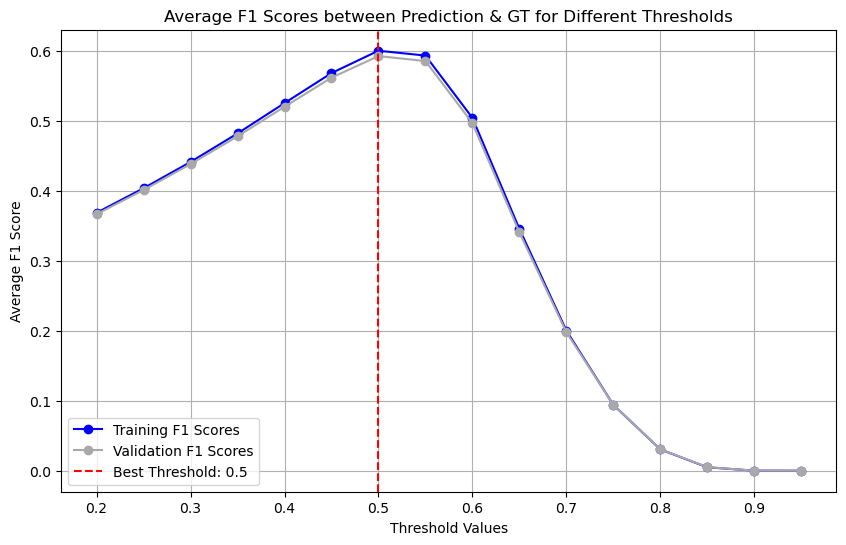

In [12]:
best_threshold_train_nLat128, avg_scores_train_nLat128 = find_best_threshold(model_nLat128, DLtrain, DEVICE, grid_size=grid_size, metric_fn=calculate_f1, thresholds=np.arange(0.2, 1.0, 0.05))
best_threshold_val_nLat128, avg_scores_val_nLat128 = find_best_threshold(model_nLat128, DLval, DEVICE, grid_size=grid_size, metric_fn=calculate_f1, thresholds=np.arange(0.2, 1.0, 0.05))

plot_scores(avg_scores_train_nLat128, avg_scores_val_nLat128, best_threshold_val_nLat128)

# Best threshold at 0.5

In [13]:
print(avg_scores_train_nLat128)
print(avg_scores_val_nLat128)

{0.2: 0.36860513426327546, 0.25: 0.40366897151492026, 0.3: 0.4412397716406341, 0.35: 0.48196409177843375, 0.39999999999999997: 0.525321779055961, 0.44999999999999996: 0.5682170933459166, 0.49999999999999994: 0.6001669906920384, 0.5499999999999999: 0.5932435142011054, 0.5999999999999999: 0.5042371417727167, 0.6499999999999999: 0.34569584663774144, 0.7: 0.20027523788667517, 0.7499999999999998: 0.0941792730513238, 0.7999999999999998: 0.03055645130429212, 0.8499999999999999: 0.004914224365205331, 0.8999999999999999: 0.00010252214590710697, 0.9499999999999997: 0.0}
{0.2: 0.36662499911111335, 0.25: 0.40117710802866063, 0.3: 0.43810488160537636, 0.35: 0.47786445688942203, 0.39999999999999997: 0.5200816052115482, 0.44999999999999996: 0.5616295530744221, 0.49999999999999994: 0.5925201855275942, 0.5499999999999999: 0.5854031818068546, 0.5999999999999999: 0.496722804269065, 0.6499999999999999: 0.34081243001248523, 0.7: 0.19804444751985695, 0.7499999999999998: 0.09416037171917117, 0.79999999999999

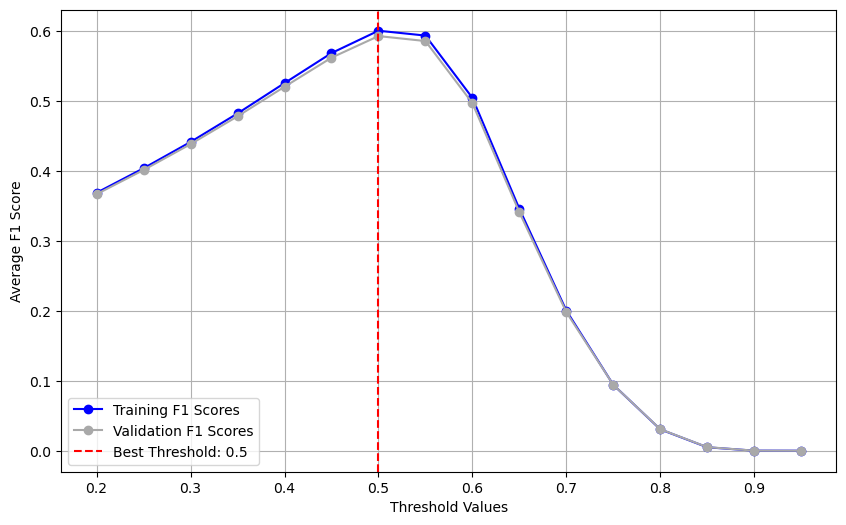

In [12]:
avg_scores_train_nLat128_save = {0.2: 0.36860513426327546, 0.25: 0.40366897151492026, 0.3: 0.4412397716406341, 0.35: 0.48196409177843375, 0.4: 0.525321779055961, 0.45: 0.5682170933459166, 0.5: 0.6001669906920384, 0.55: 0.5932435142011054, 0.6: 0.5042371417727167, 0.65: 0.34569584663774144, 0.7: 0.20027523788667517, 0.75: 0.0941792730513238, 0.8: 0.03055645130429212, 0.85: 0.004914224365205331, 0.9: 0.00010252214590710697, 0.95: 0.0}
avg_scores_val_nLat128_save = {0.2: 0.36662499911111335, 0.25: 0.40117710802866063, 0.3: 0.43810488160537636, 0.35: 0.47786445688942203, 0.4: 0.5200816052115482, 0.45: 0.5616295530744221, 0.5: 0.5925201855275942, 0.55: 0.5854031818068546, 0.6: 0.496722804269065, 0.65: 0.34081243001248523, 0.7: 0.19804444751985695, 0.75: 0.09416037171917117, 0.8: 0.030766877667654468, 0.85: 0.0051397500019368676, 0.9: 9.005665038864169e-05, 0.95: 0.0}
plot_scores(avg_scores_train_nLat128_save, avg_scores_val_nLat128_save, best_threshold=0.5)

### Precision, Recall

In [11]:
precision_dense128, recall_dense128 = evaluate_precision_recall(model_dense128, DLval, DEVICE, grid_size)
print(f"Precision: {precision_dense128}, Recall: {recall_dense128}")

Precision: 0.5940729777450147, Recall: 0.8563194356534792


In [12]:
precision_nLat128, recall_nLat128 = evaluate_precision_recall(model_nLat128, DLval, DEVICE, grid_size)
print(f"Precision: {precision_nLat128}, Recall: {recall_nLat128}")

Precision: 0.48577222999023356, Recall: 0.7630455374717713


### Plots of 128 resolution Neurons
#### Dense

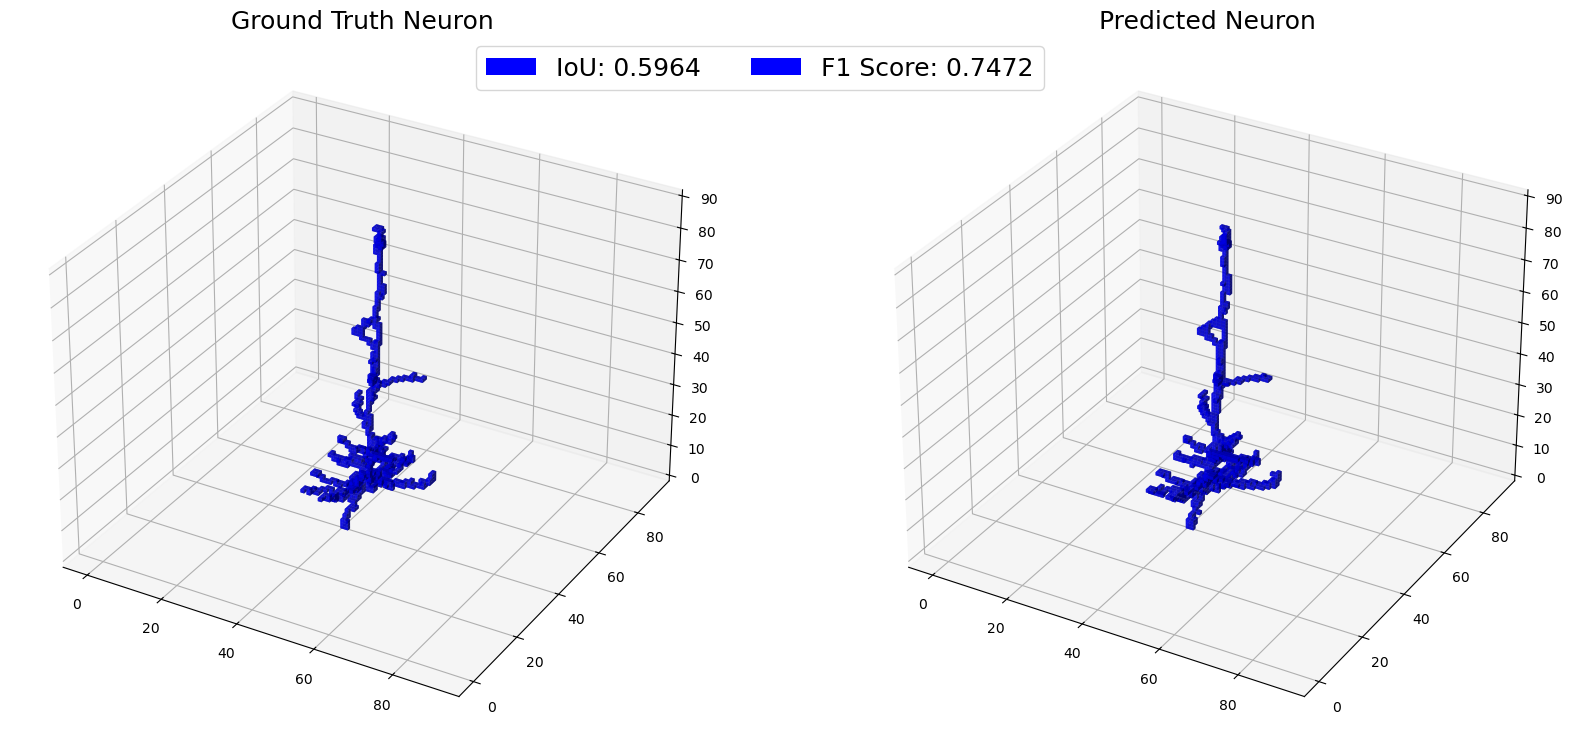

In [11]:
crop_percentage = 0.15

plot_prediction(model_dense128, datav, DEVICE, grid_size, threshold=0.55,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=1, font_size=18)

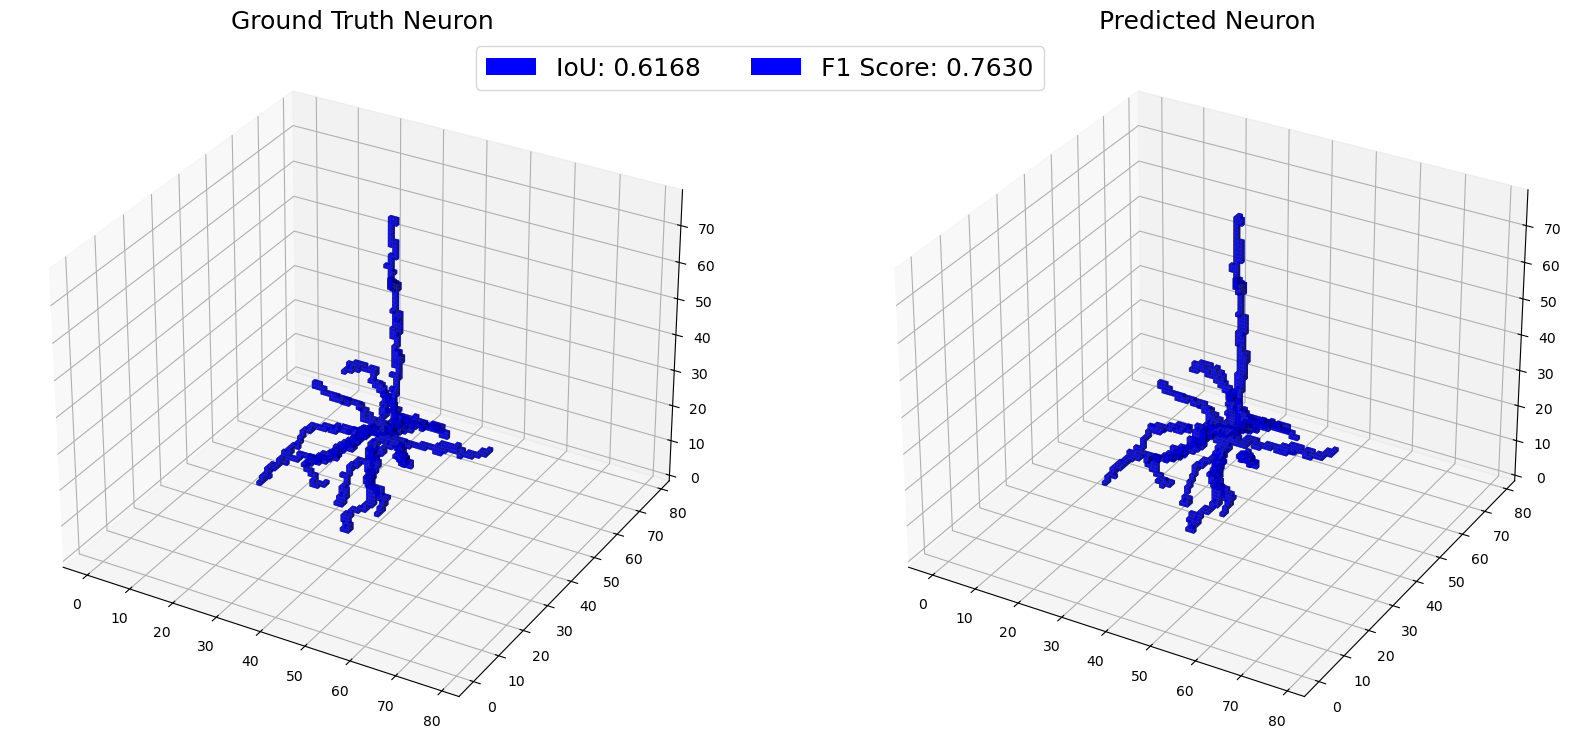

In [12]:
crop_percentage = 0.20

plot_prediction(model_dense128, datav, DEVICE, grid_size, threshold=0.55,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=3, font_size=18)

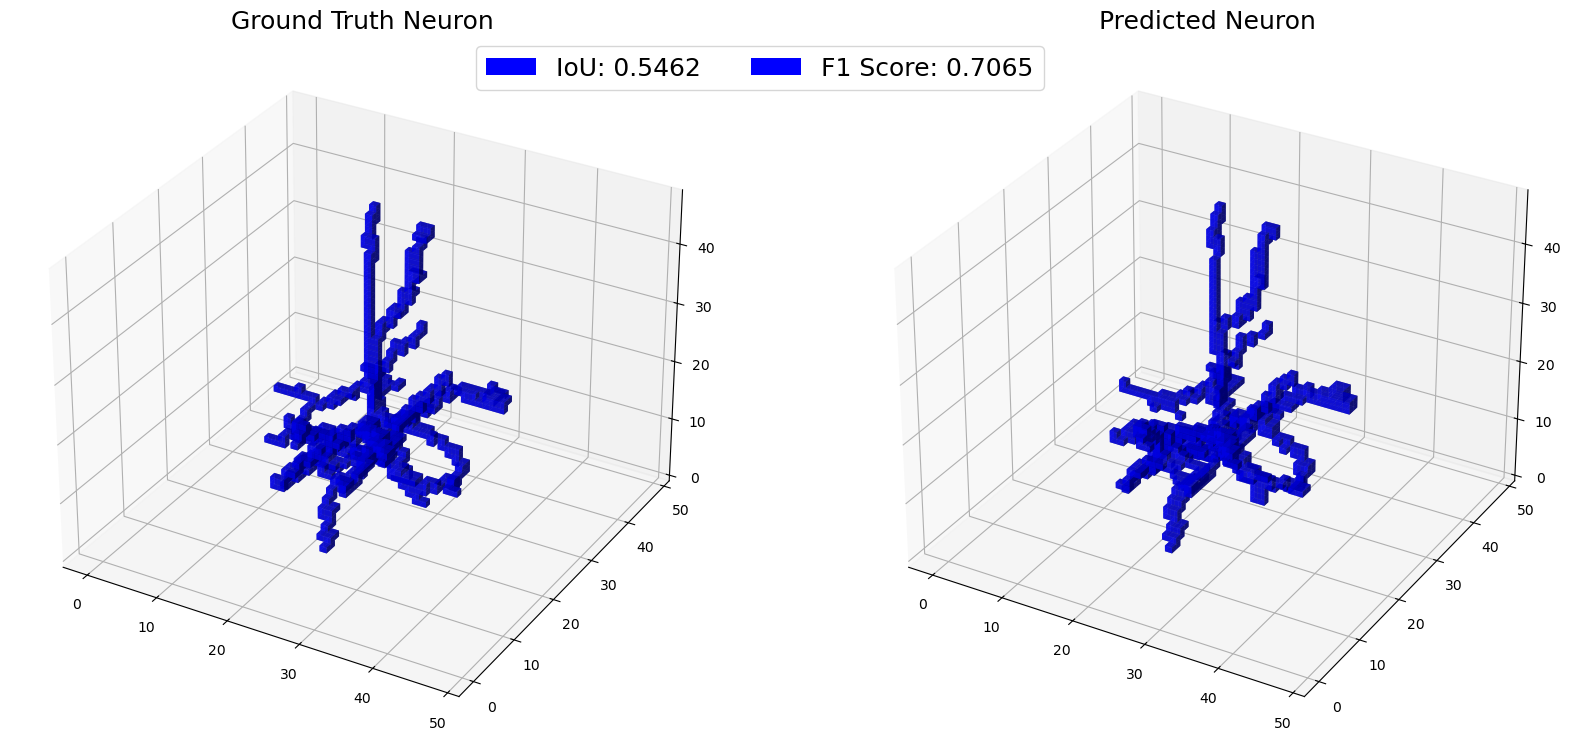

In [13]:
crop_percentage = 0.32

plot_prediction(model_dense128, datat, DEVICE, grid_size, threshold=0.55,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=0, font_size=18)

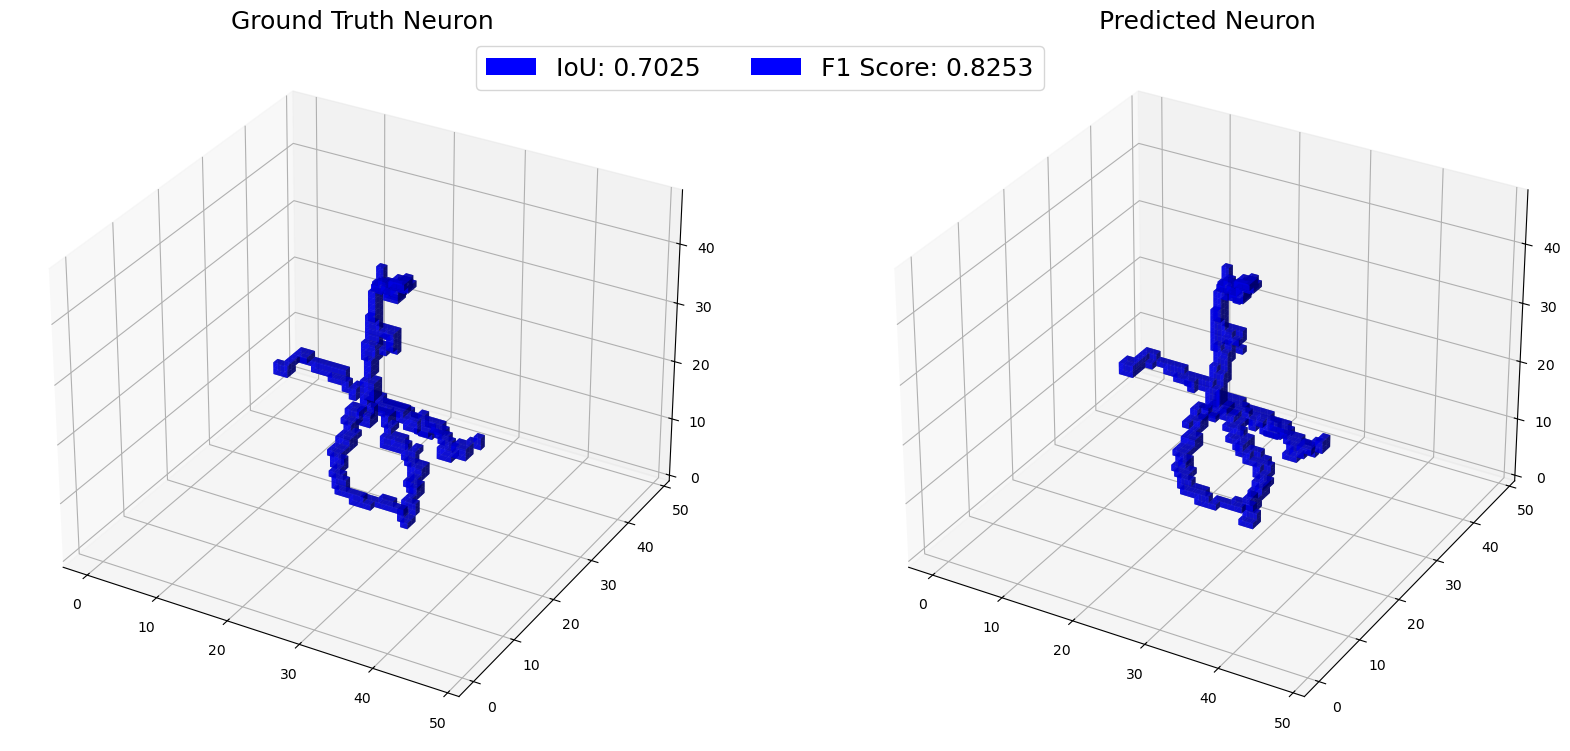

In [14]:
crop_percentage = 0.32

plot_prediction(model_dense128, datat, DEVICE, grid_size, threshold=0.55,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=9, font_size=18)

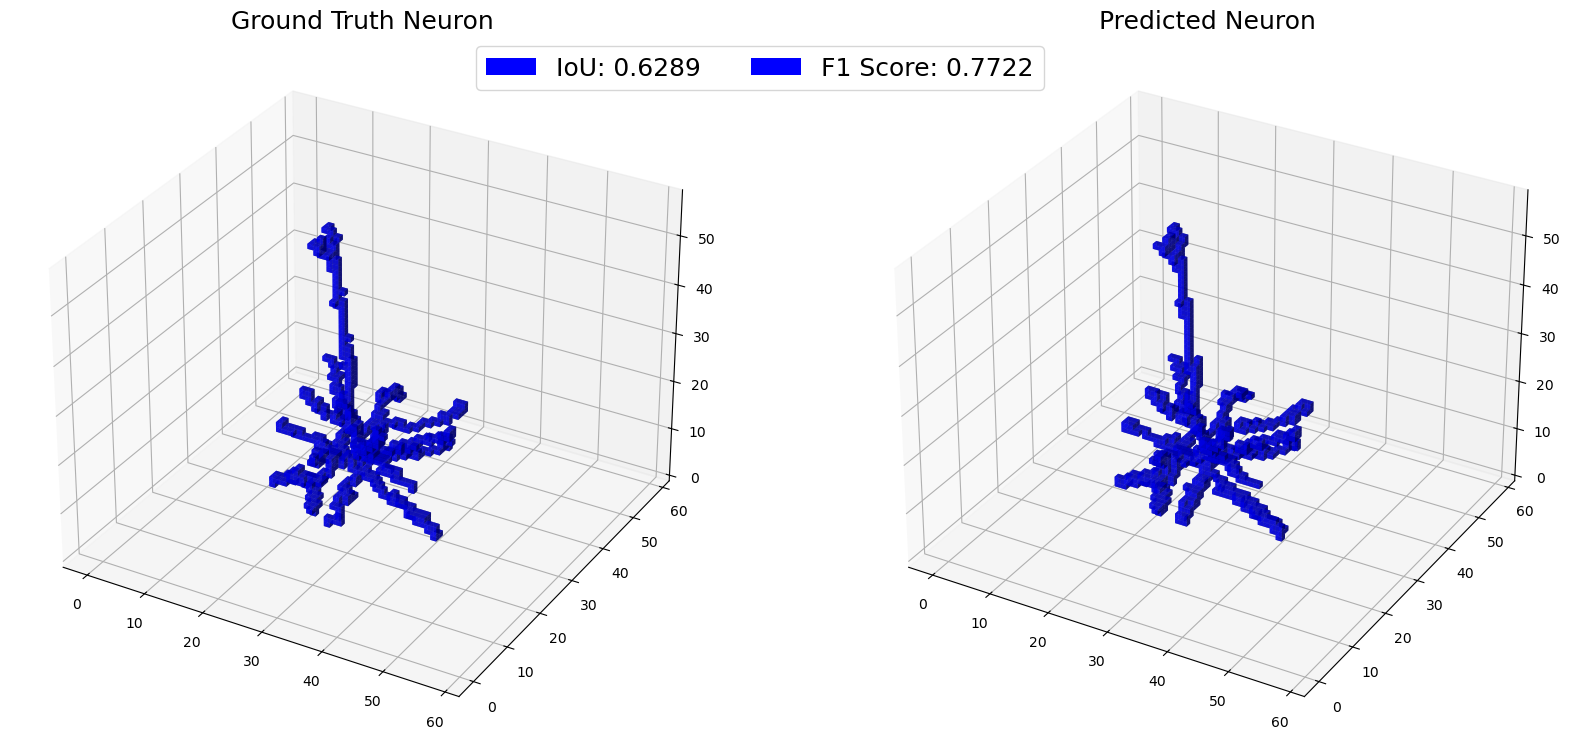

In [15]:
crop_percentage = 0.28

plot_prediction(model_dense128, datatest, DEVICE, grid_size, threshold=0.55,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=7, font_size=18)

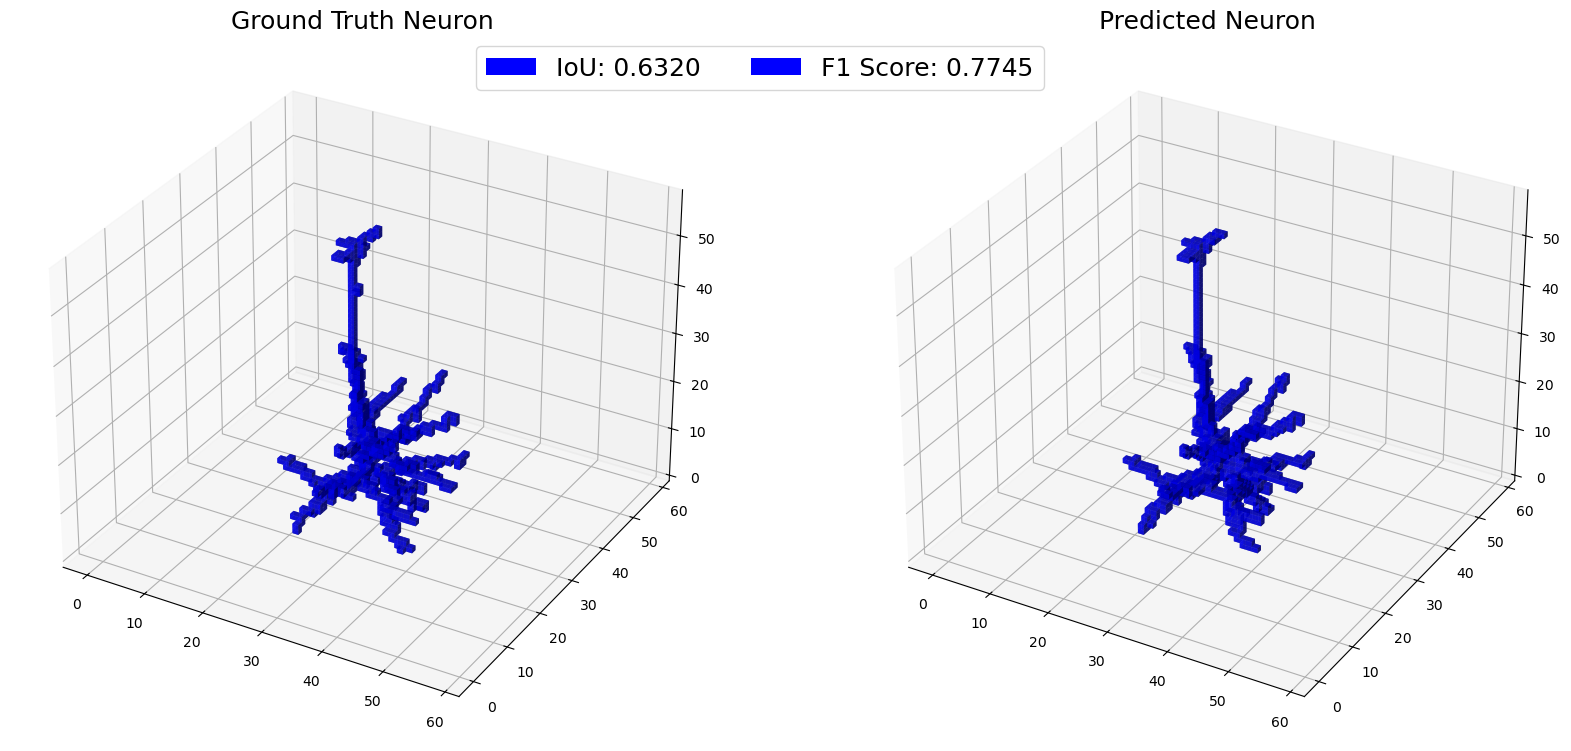

In [16]:
crop_percentage = 0.28

plot_prediction(model_dense128, datatest, DEVICE, grid_size, threshold=0.55,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=9, font_size=18)

#### nLat

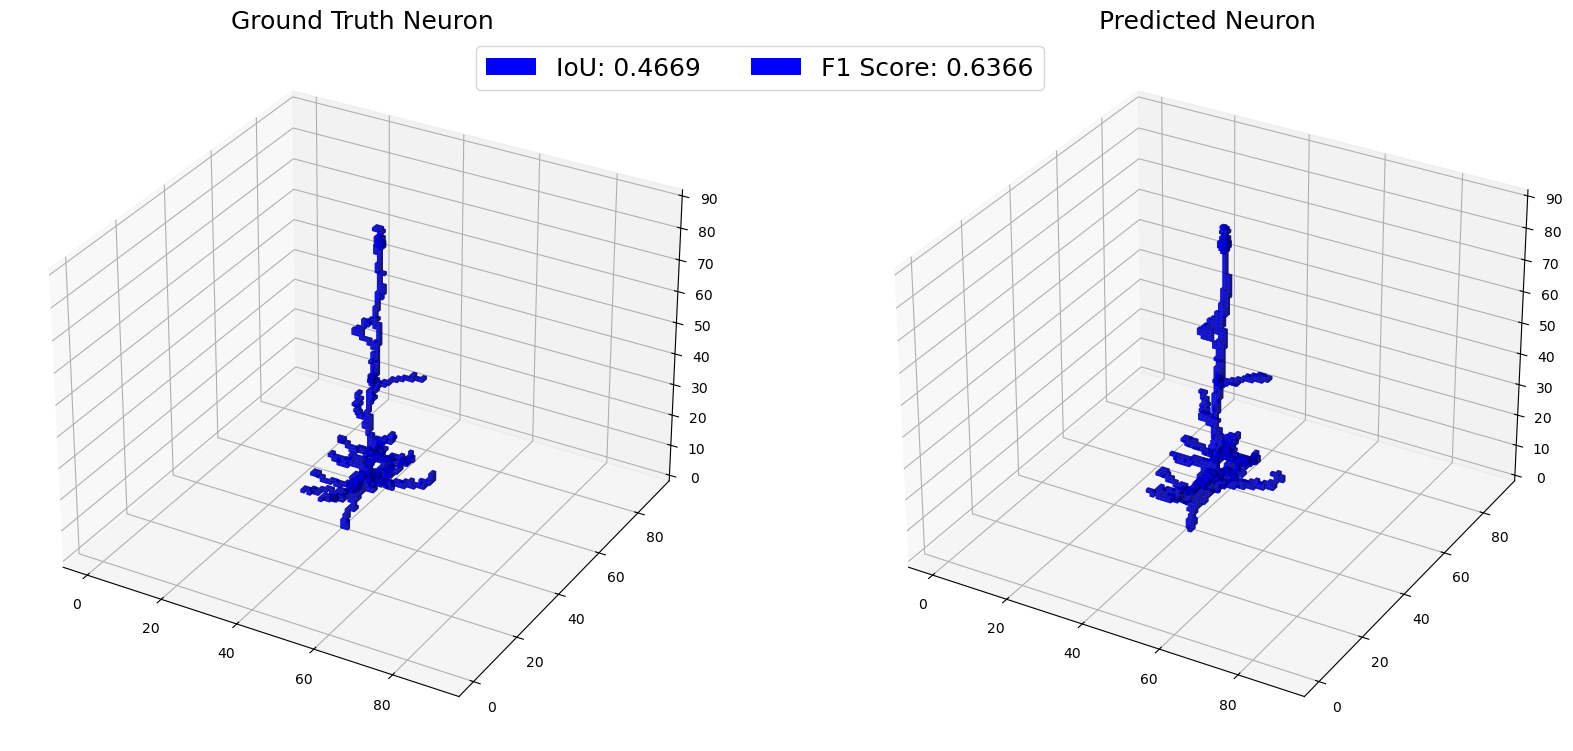

In [17]:
crop_percentage = 0.15
plot_prediction(model_nLat128, datav, DEVICE, grid_size, threshold=0.5,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=1, font_size=18)

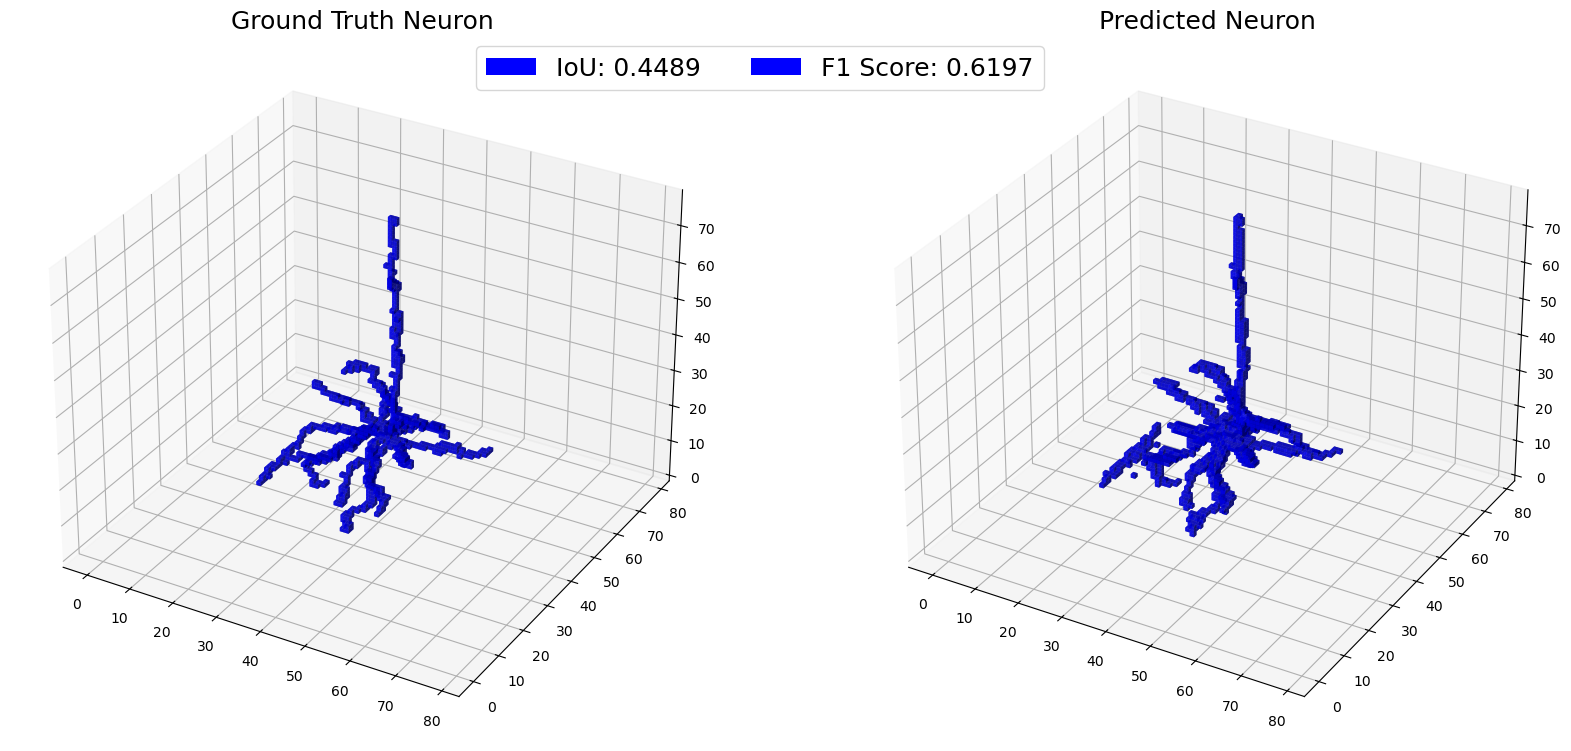

In [18]:
crop_percentage = 0.20
plot_prediction(model_nLat128, datav, DEVICE, grid_size, threshold=0.5,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=3, font_size=18)

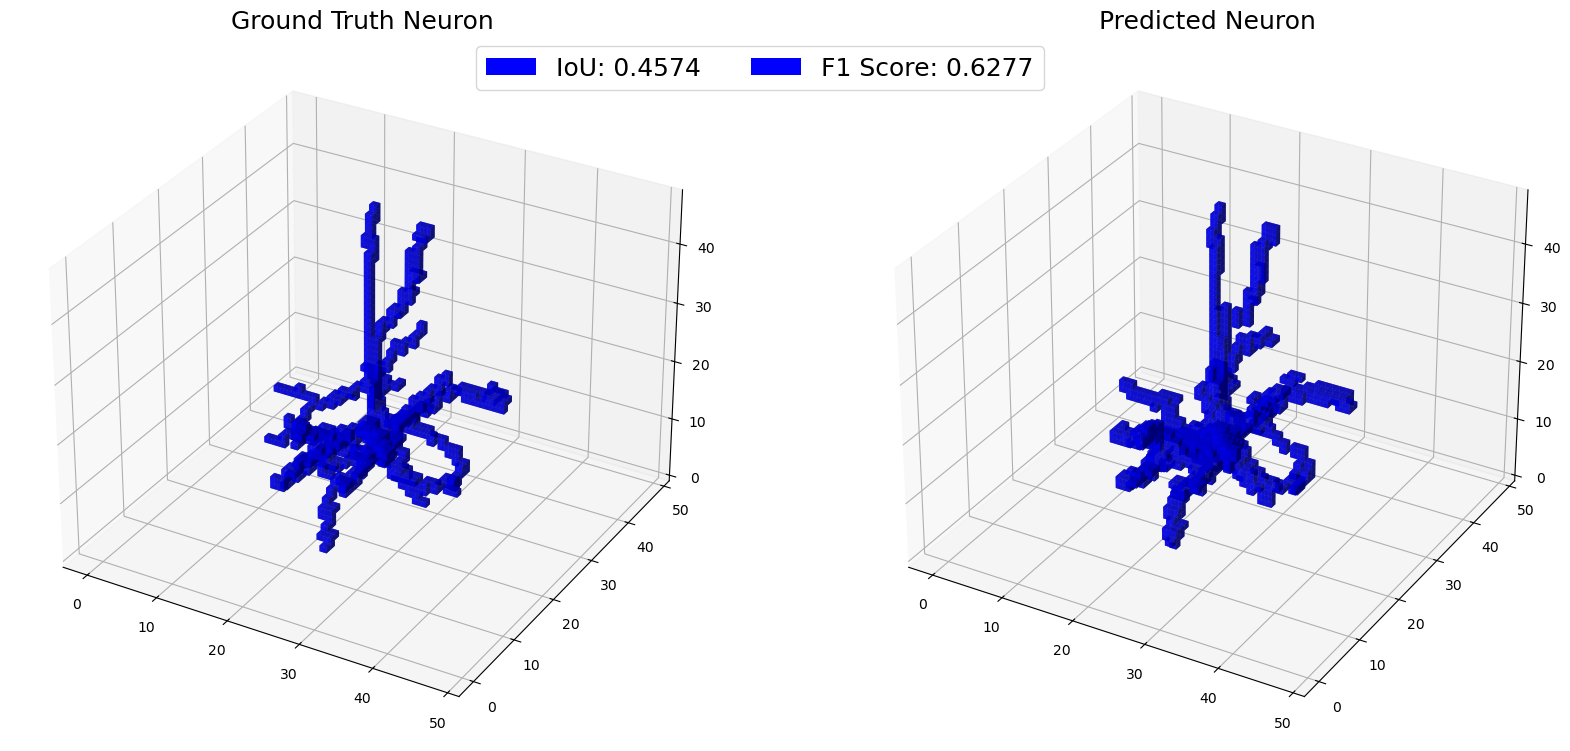

In [19]:
crop_percentage = 0.32
plot_prediction(model_nLat128, datat, DEVICE, grid_size, threshold=0.5,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=0, font_size=18)

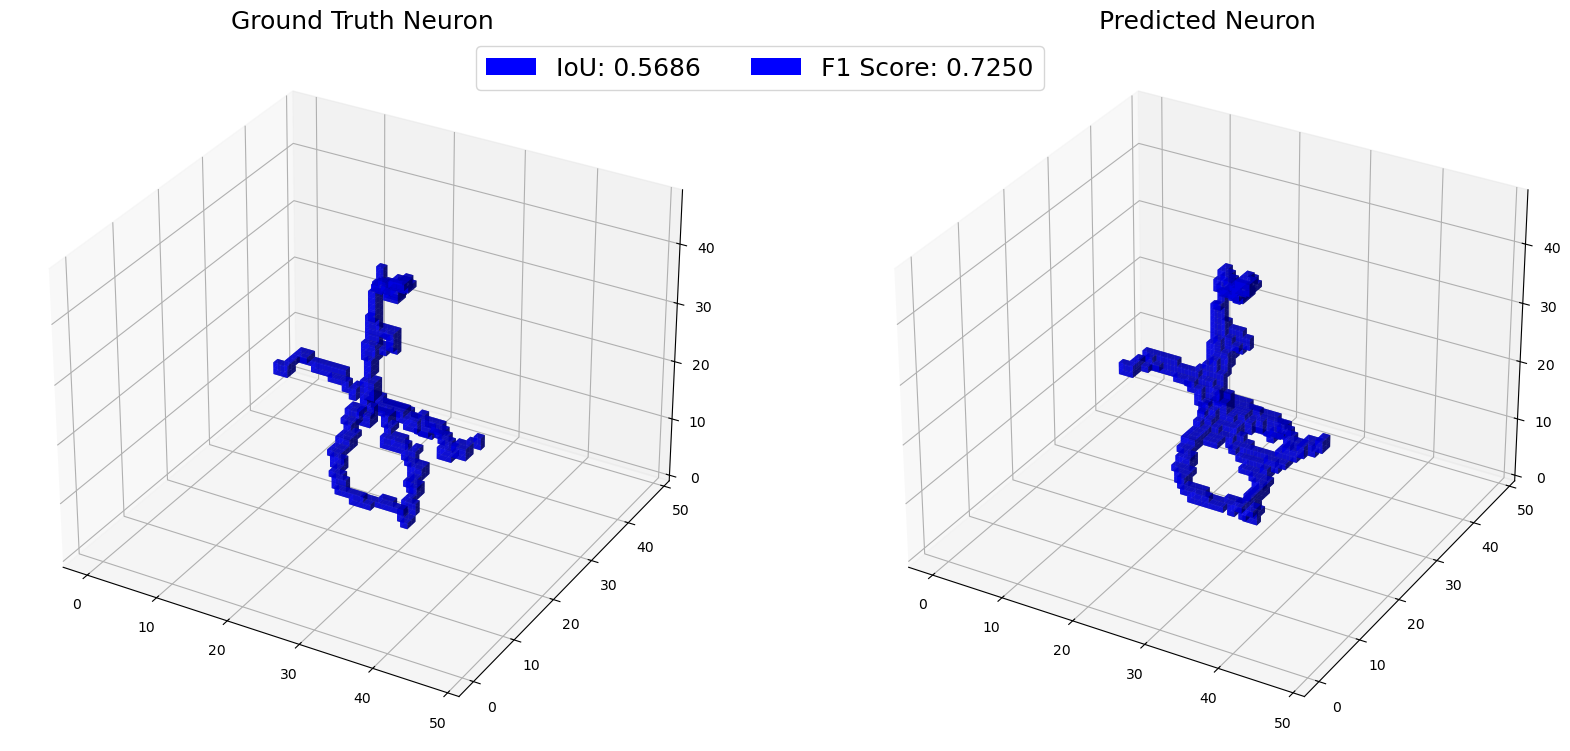

In [20]:
crop_percentage = 0.32
plot_prediction(model_nLat128, datat, DEVICE, grid_size, threshold=0.5,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=9, font_size=18)

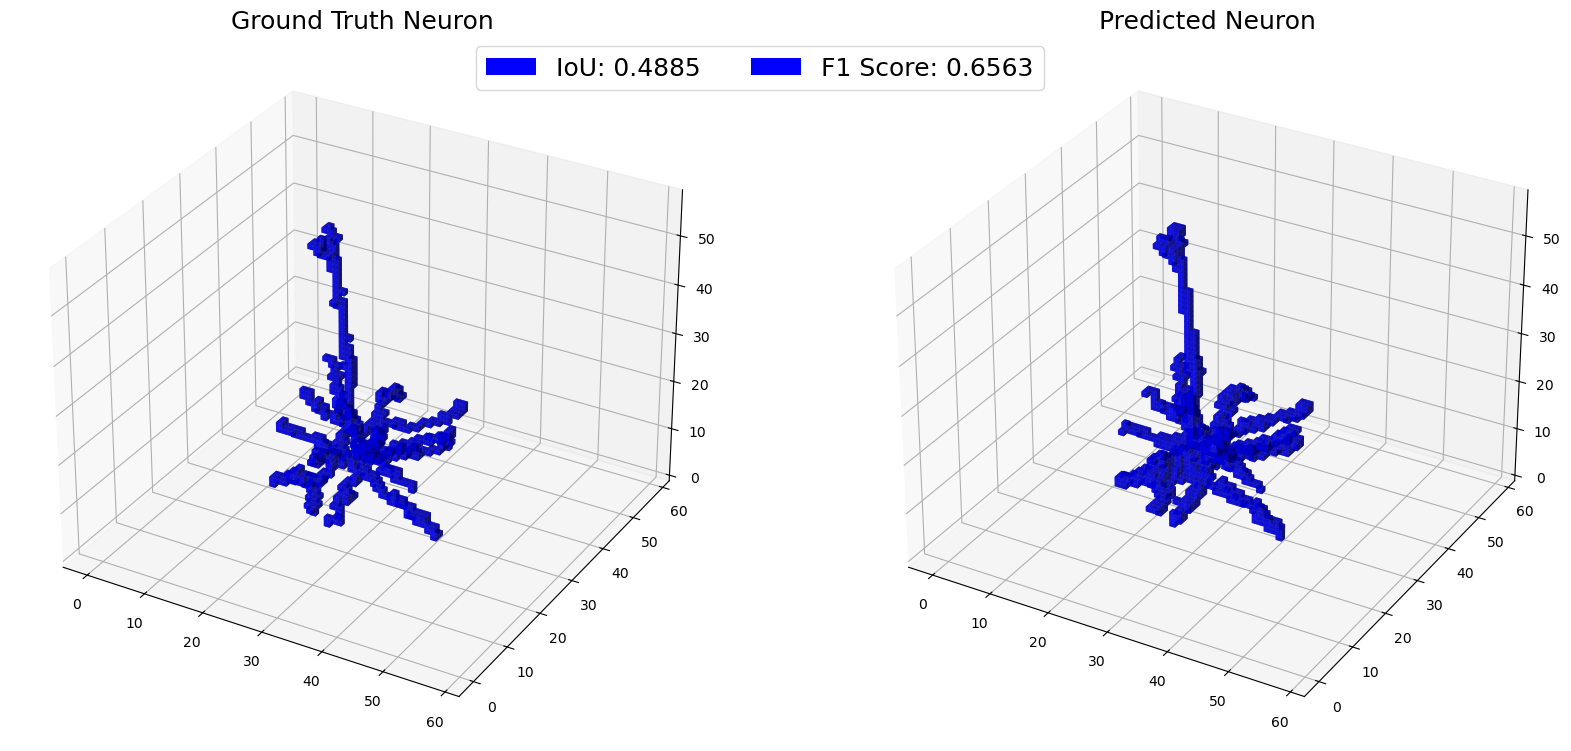

In [21]:
crop_percentage = 0.28
plot_prediction(model_nLat128, datatest, DEVICE, grid_size, threshold=0.5,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=7, font_size=18)

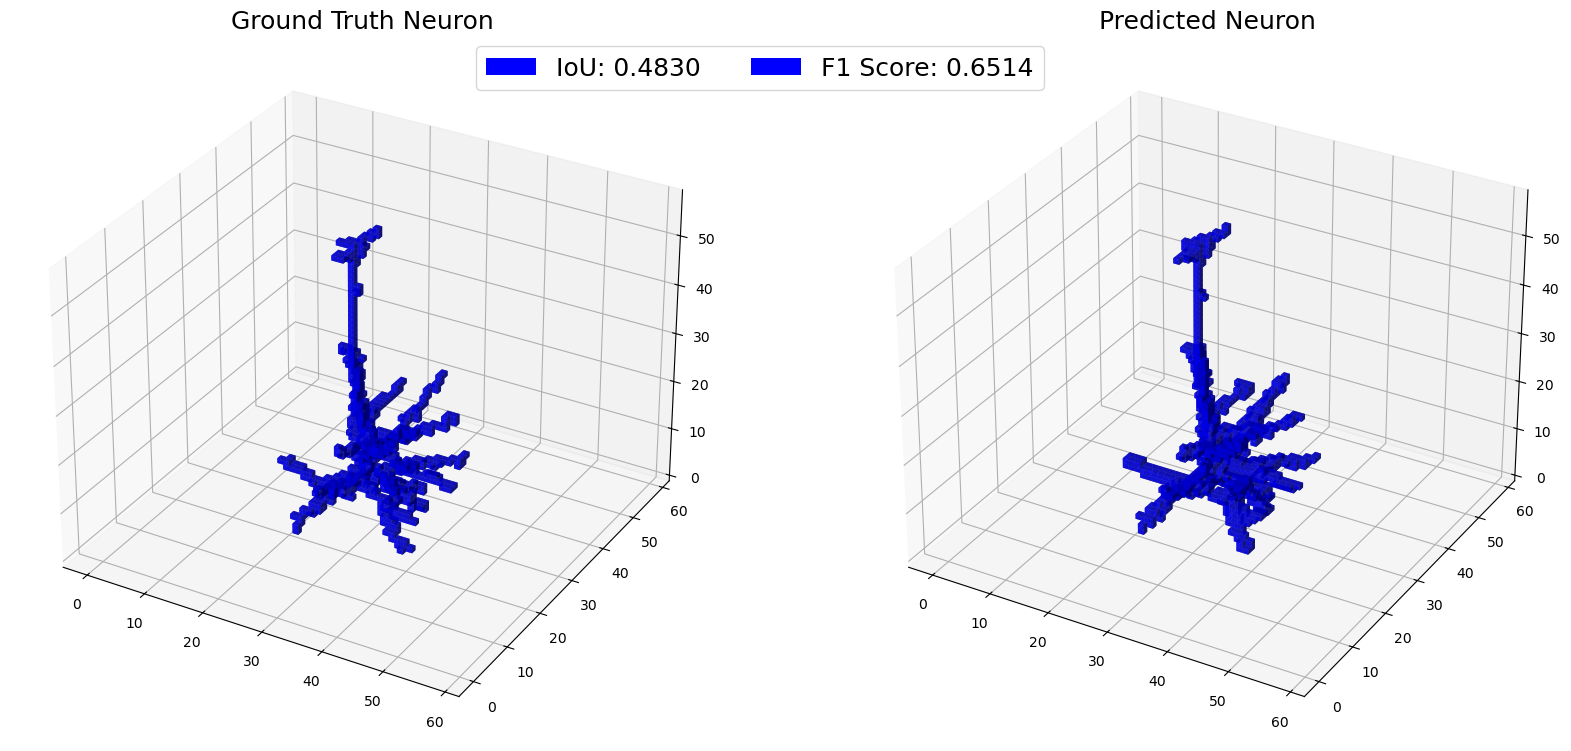

In [22]:
crop_percentage = 0.28
plot_prediction(model_nLat128, datatest, DEVICE, grid_size, threshold=0.5,
                crop_percentage=crop_percentage, alpha=0.75, neuron_idx=9, font_size=18)